<a href="https://colab.research.google.com/github/nurriol2/forecasting/blob/ft-lstm/LSTM_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Standard Imports ##

Since I'm using a dark theme on Google Colab, I manually set some color parameters for plots generated by matplotlib.

In [24]:
import numpy as np 
import pandas as pd

import torch 
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'

## Collecting Data ##

A `.csv` with the data is already uploaded to the GitHub repository. Specifically, the appended old school bond data found on `ft-lstm`.

One limitation I have throughout this project is that the OSRS Grand Exchange only provides a 180-day snapshot of price (and volume) data. 

So, I use another small script to append future data points. This enlarged dataset is denoted in the filename
`old_school_bond_appended.csv`.

In [2]:
#get csv with bond data
bond_data = pd.read_csv("https://raw.githubusercontent.com/nurriol2/forecasting/ft-lstm/datasets/old_school_bond_appended.csv")

#check that retrieved the expected data
bond_data.head()

,Index,Timestamps_close,Close,Timestamps_average,Average
0,0,2020/04/08,4134618,2020/04/08,4522980
1,1,2020/04/09,4009639,2020/04/09,4501601
2,2,2020/04/10,3903868,2020/04/10,4473252
3,3,2020/04/11,3853462,2020/04/11,4442300
4,4,2020/04/12,3941327,2020/04/12,4415261


In [3]:
#close = bond_data["Close"]
#close.describe()

In [4]:
tesla = pd.read_csv("/content/TSLA.csv")
print(tesla.describe())
close = tesla["Close"]

              Open         High  ...    Adj Close        Volume
count  1259.000000  1259.000000  ...  1259.000000  1.259000e+03
mean     64.594124    65.883341  ...    64.642060  3.810405e+07
std      33.400757    34.457933  ...    33.518742  2.815214e+07
min      28.464001    30.993999  ...    28.733999  3.540000e+06
25%      45.861999    46.425002  ...    45.887001  2.093825e+07
50%      56.765999    57.888000  ...    56.945999  2.989350e+07
75%      67.962001    69.039002  ...    67.790001  4.401650e+07
max     281.002014   285.899994  ...   278.855988  3.046940e+08

[8 rows x 6 columns]


## Models will learn from sequences ##

An important assumption of the time series is that past prices influence future ones. We can use this assumption to create datasets for training the model.

- Fixed length sequences are an element of the input tensor (`X`) 
    - The *sequence length* is tunable and is generally chosen based on domain knowledge
- The correct future price is an element of the output tensor (`y`)
    

Training and testing series are sliced out of `old_school_bond_appended.csv`. 

## Example ##
Consider `data = [1,2,3,4,5,6,7,8,9,10]` the price data. If we have a `sequence_length` of 2 days, then our `X_example` and `y_example` look like this:

`X_example = [[1,2],[2,3], [3,4]...[8, 9]]`  
`y_example = [3, 4, 5...10]`

Notice that the identical indices of these 2 tensors make up one input-output pair.

In [5]:
def create_sequences(dataset, seq_len):
    xs = []
    ys = []

    for i in range(len(dataset)-seq_len):
        xs.append(dataset[i:i+seq_len])
        ys.append(dataset[i+seq_len])
        
    return np.asarray(xs), np.asarray(ys)  

In [6]:
#define a train-test split ratio
train_size = int(len(bond_data)*.70)

#slice out the training data
training_data = close[:train_size].to_numpy()
#slice out the test data 
test_data = close[train_size:].to_numpy()

In [7]:
class CustomScaler:

    def __init__(self, dmin, dmax):
        self.dmin = dmin
        self.dmax = dmax
        return

    def fit_transform(self, array):
        return (array - self.dmin)/(self.dmax - self.dmin)

    def inverse_transform(self, array):
        return (array*(self.dmax - self.dmin) + self.dmin)

In [8]:
def scale_array(scaler_obj, array):
    """
    Scale an array according to a scaler object, then convert the array to 
    a PyTorch tensor.

    Args:
    scaler_obj (sklearn Scaler):  The scaler object from SciKitLearn that defines
    the scaling transform

    array (numpy.ndarray):  An array of the data to be transformed

    Returns:
    (torch.Tensor):  PyTorch Tensor representation of the scaled array
    """

    #the same as array, after being transformed by the scaler_obj
    scaled_array = None

    #check that the dataset array is 2 dimensional
    if array.ndim==2:
        #scaled dataset array
        scaled_array = scaler_obj.fit_transform(array)
    #the dataset is not 2 dimensional
    else:
        #reshape the data 
        array = array.reshape(-1, 1)
        #return scaled data
        scaled_array = scaler_obj.fit_transform(array)

    scaled_tensor = torch.from_numpy(scaled_array).float()

    return scaled_tensor

#object to scale values between 0 and 1
#scaler = MinMaxScaler(feature_range=(0, 1))
train_min = training_data.min()
train_max = training_data.max()
scaler = CustomScaler(train_min, train_max)

training_data = scale_array(scaler, training_data).flatten().numpy()
test_data = scale_array(scaler, test_data).flatten().numpy()


In [9]:
training_data

array([0.754645  , 0.78660154, 0.8236544 , 0.79700595, 0.8345896 ,
       0.919312  , 1.        , 0.8355452 , 0.84722376, 0.84011036,
       0.8211064 , 0.6894576 , 0.8148424 , 0.8042255 , 0.8357576 ,
       0.82896274, 0.7635631 , 0.830343  , 0.87121785, 0.6164138 ,
       0.5779807 , 0.56343573, 0.52341014, 0.5319036 , 0.5779807 ,
       0.58477557, 0.7104789 , 0.77131337, 0.7132392 , 0.5744772 ,
       0.453339  , 0.3269986 , 0.33931428, 0.39038116, 0.5830768 ,
       0.6413632 , 0.647521  , 0.5367875 , 0.6329758 , 0.61046815,
       0.57182306, 0.63807195, 0.64592856, 0.6413632 , 0.6600489 ,
       0.6913685 , 0.695403  , 0.7875571 , 0.7856461 , 0.7702517 ,
       0.8082599 , 0.77364904, 0.77492315, 0.7967938 , 0.73086315,
       0.6408324 , 0.62193453, 0.6405139 , 0.55005854, 0.63170195,
       0.616626  , 0.566833  , 0.465973  , 0.41034096, 0.34632134,
       0.29206935, 0.331033  , 0.30587113, 0.3529038 , 0.41341975,
       0.42499205, 0.26499632, 0.23378296, 0.2510884 , 0.22316

In [10]:
test_data

array([ 0.03323091,  0.09417145, -0.05616296, ..., 12.759208  ,
       12.504617  , 12.806134  ], dtype=float32)

In [11]:
X_train, y_train = create_sequences(training_data, 5)
#(number of sequences, length of sequences), (number of predicted values)
print(X_train.shape, y_train.shape)

X_test, y_test = create_sequences(test_data, 5)
print(X_test.shape, y_test.shape)

(135, 5) (135,)
(1114, 5) (1114,)


In [12]:
X_train[0], X_train[1][-1], y_train[0]

(array([0.754645  , 0.78660154, 0.8236544 , 0.79700595, 0.8345896 ],
       dtype=float32), 0.919312, 0.919312)

In [13]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train).view(-1, 1)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test).view(-1, 1)

In [14]:
n_sequences, len_sequences = X_train.shape

## Defining a Baseline:  Mean Predictor ##

I want to be able to discuss how the LSTM is performing. A relatively simple way to accomplish this is to use one model's performance as a *baseline* for how good (or bad) other models are doing.

For this experiment, I chose a mean predictor. The mean predictor will also work with sequences to predict the next value. This value is always the mean (average) of the input sequence. 

Some guiding principles on choosing a  "good" baseline for your use case can be found [here](https://blog.ml.cmu.edu/2020/08/31/3-baselines/). For a more time series focused example on baseline predictions, check out [this article from Jason Brownlee](https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/). 

In [15]:
class MeanModel(nn.Module):

    def __init__(self):
        super(MeanModel, self).__init__()
        return

    def forward(self, x):
        return torch.mean(x)

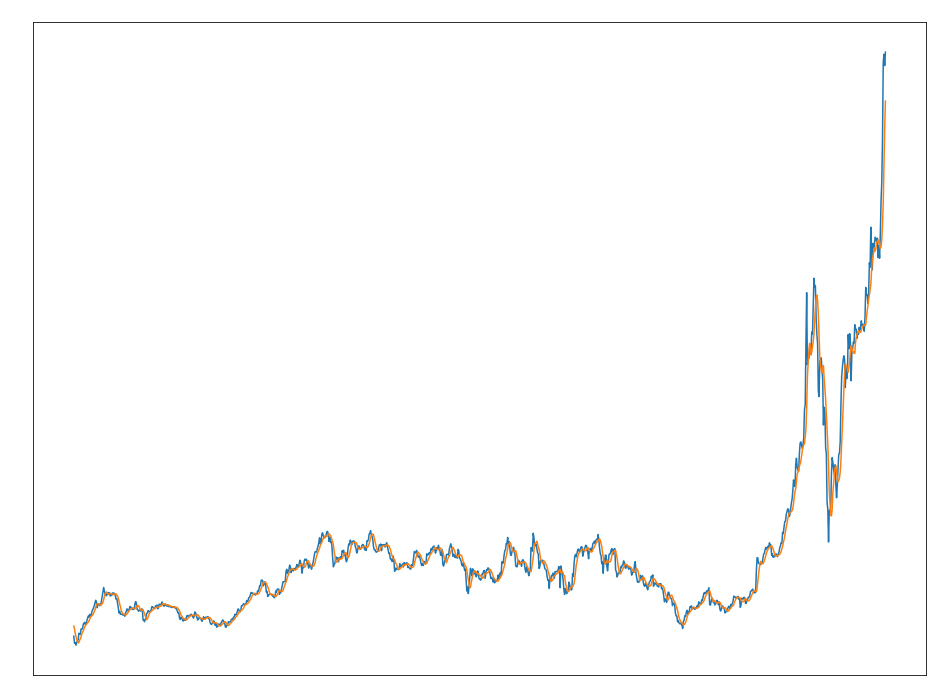

In [25]:
meanmodel = MeanModel()

mean_preds = []
for sequence in X_test:
    pred = meanmodel(sequence)
    mean_preds.append(pred)

#convert mean list to tensor
mean_preds = torch.FloatTensor(mean_preds)

#inverse transform the scaled predictions 
true_price = scaler.inverse_transform(np.expand_dims(y_test.flatten().numpy(), axis=0)).flatten()
predicted_price_mean = scaler.inverse_transform(np.expand_dims(mean_preds, axis=0)).flatten()

#concurrently plot the true sequence and predicted sequence
plt.plot(true_price)
plt.plot(predicted_price_mean)
plt.title("Predicted Price with Actual Price (Mean Predictor)")
plt.show()

#this is the same procedure I'll follow when predicting prices with the next model

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(LSTMModel, self).__init__()

        self.n_features = n_features
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.2
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

        return 

    def init_hidden(self):
        return (torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
         torch.zeros(self.n_layers, self.seq_len, self.n_hidden))

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1), self.init_hidden())
        
        last_time_step = lstm_out.view((self.seq_len, len(sequences), self.n_hidden))[-1]
        
        y_pred = self.linear(last_time_step)
        
        return y_pred

In [18]:
#wrap training into a function
def train_model(model, num_epochs, learning_rate, criterion, optimizer, X_train, y_train, X_test, y_test):
    #arrays that hold calculated loss at every epoch step
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    #training loop (both training and test data)
    for epoch in range(num_epochs):
        model.init_hidden()
        #make a prediction based on training data
        y_pred = model(X_train)
        #calculate the loss of that data wrt known labels
        loss = criterion(y_pred.float(), y_train)
            
        #update the training history 
        train_hist[epoch] = loss.item()

        #propogate the update backwards
        loss.backward()
        #adjust the weights and biases of the model
        optimizer.step()

        #clear the accumulated gradient
        optimizer.zero_grad()

        #print milestone statistics
        if epoch%10==0:
            print(f"Epoch {epoch} Train Loss {loss.item():.3f}")

        #switch off layers for evaluation
        #NB:  only affects certain layers (e.g nn.Droput)
        model.train()

        #enter test data 
        with torch.no_grad():
            #make a prediction on the test data
            y_test_pred = model(X_test)
            #calculate the test loss
            test_loss = criterion(y_test_pred.float(), y_test)
            #update the test history 
            test_hist[epoch] = test_loss.item()

        #print milestone statistics
        if epoch%10==0:
            print(f"Epoch {epoch} Train Loss {loss.item():.3f} Test Loss {test_loss.item():.3f}")
    
    return train_hist, test_hist

In [19]:
#LSTM architecture model
lstm_model = LSTMModel(n_features=1, n_hidden=250, seq_len=len_sequences, n_layers=2)

#LSTM Parameters
num_epochs = 50
learning_rate = 2e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

#train the LSTM
lstm_train_hist, lstm_test_hist = train_model(lstm_model, num_epochs=num_epochs, learning_rate=learning_rate, criterion=criterion, optimizer=optimizer, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

Epoch 0 Train Loss 0.241
Epoch 0 Train Loss 0.241 Test Loss 5.210
Epoch 10 Train Loss 0.101
Epoch 10 Train Loss 0.101 Test Loss 4.987
Epoch 20 Train Loss 0.058
Epoch 20 Train Loss 0.058 Test Loss 3.827
Epoch 30 Train Loss 0.049
Epoch 30 Train Loss 0.049 Test Loss 4.069
Epoch 40 Train Loss 0.046
Epoch 40 Train Loss 0.046 Test Loss 3.547


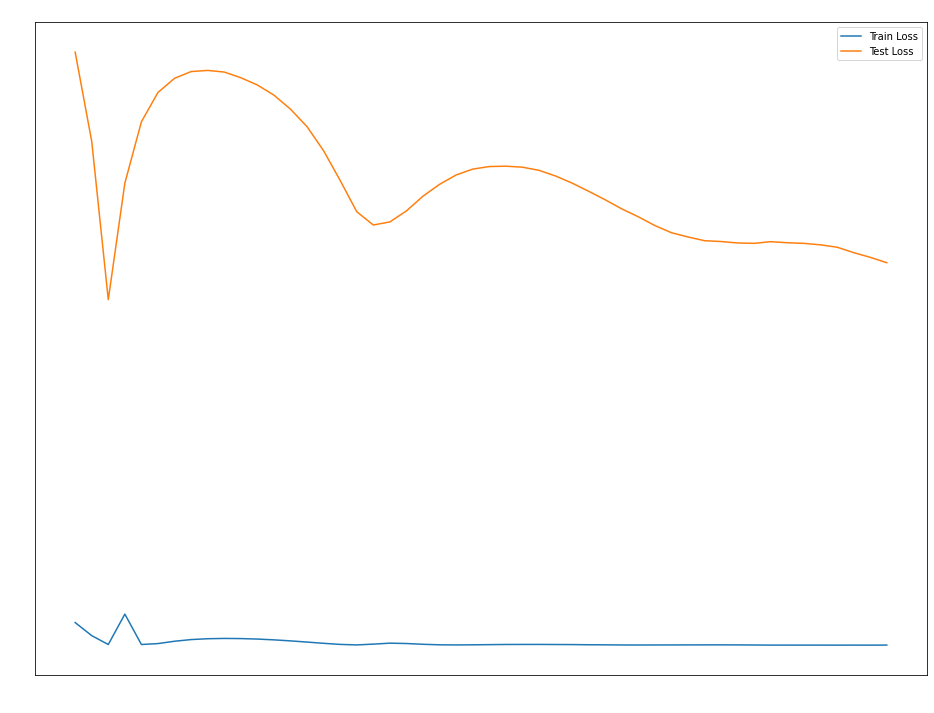

In [26]:
#plot the results
#plot the loss per epoch for the logistic regression model
plt.plot(lstm_train_hist, label="Train Loss")
plt.plot(lstm_test_hist, label="Test Loss")
plt.title("LSTM Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

In [21]:
#we want to use the current model state to make a prediction
#turn off gradient calculations
with torch.no_grad():

    lstm_model.eval()

    #use single element tensor to make a test input sequence
    test_seq = X_test[:1]
    #container for model predictions
    preds = []
    
    #prediction should be equal in length to the test sequence
    for _ in range(len(X_test)):
        #the prediction made by the model (a sequence)
        y_test_pred = lstm_model(test_seq)
        #reshape the prediction
        pred = torch.flatten(y_test_pred).item()
        #update the prediction container with the elements of the prediction
        preds.append(pred)

        #reshape the test sequence
        new_seq = test_seq.numpy().flatten()
        #append the predicted sequence as a 2d list
        new_seq = np.append(new_seq, [pred])
        #shift 1 element to the right in the sequence
        new_seq = new_seq[1:]
        #create a tensor from this new sequence
        #reshape tensor
        test_seq = torch.as_tensor(new_seq).view(1, lstm_model.seq_len, 1).float()

In [22]:
true_price_lstm = scaler.inverse_transform(np.expand_dims(y_test.flatten().numpy(), axis=0)).flatten()
predicted_price_lstm = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()

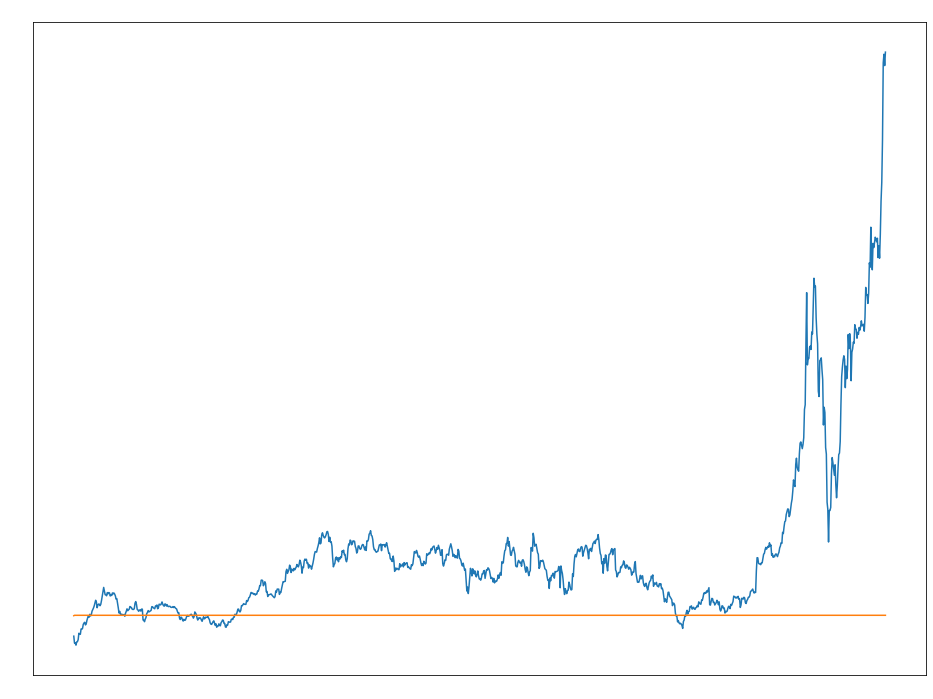

In [27]:
plt.plot(true_price_lstm)
plt.plot(predicted_price_lstm)
plt.title("Predicted Price with Actual Price (LSTM)")
plt.show()